## Novel Molecule Generation using Bidirectional-Recurrent Neural Networks with Attention Applied to Simplified Molecular Input Line Entry Sysem (SMILES)

## Train

author: anthony j. vasquez
email: vanthony715@gmail.com / avasque1@jh.edu

In [1]:
import time
from datetime import datetime
t0 = time.time()

import sys
sys.path.append('./data/')

import gc
gc.collect()

import os
##had a hard time with this setting on windows os using spyder and jypyter
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import warnings
warnings.filterwarnings("ignore")

import platform
print("Operating System: ", platform.system())
print("Machine Type:: ", platform.machine())

import multiprocessing as mp
max_processors = mp.cpu_count()
print('Processor Count: ', max_processors, '\n')

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from rdkit import Chem
from rdkit.Chem import BRICS
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Descriptors import CalcMolDescriptors
from rdkit.Chem.rdMolDescriptors import GetHashedMorganFingerprint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

from net import *
from utils import *
from custom_dataset import *

if torch.cuda.is_available():
    torch.cuda.empty_cache() #empty cache
    print('CUDA Version')
    print(f'CUDNN Version: {torch.backends.cudnn.version()}')
    print(f'Number of CUDA Devices: {torch.cuda.device_count()}')
    print(f'Active CUDA Device: {torch.cuda.current_device()}')
    print(f'Available devices: {torch.cuda.device_count()}, Name: {torch.cuda.get_device_name(0)}')
    print(f'Current CUDA device: {torch.cuda.current_device()}')
    print('\n')

##hardware params
# DEVICE = torch.device('cpu') #DEBUG
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device: \n', DEVICE)

Operating System:  Linux
Machine Type::  x86_64
Processor Count:  24 

CUDA Version
CUDNN Version: 90100
Number of CUDA Devices: 2
Active CUDA Device: 0
Available devices: 2, Name: NVIDIA RTX A4000
Current CUDA device: 0


Using Device: 
 cuda


#### Hyperparameters

In [2]:
##OS
LINUX = True
MULTI_GPU = True #trains using multiple gpus
N_PROCESSORS = max_processors - 2

##data
HOLDOUT_PERC = 0.90
TRAIN_BS = 128 #train batch size
PREFETCH_FACTOR = 4 #effectively reduces gpu load time 
NUM_WORKERS = 8

'''
Current Best Config:
Best trial config: {'lr_g': 0.0001413635808908355, 'lr_d': 0.016875269365452798, 'batch_size': 128, 'hidden_dim': 16, 
                    'optimizer': 'rmsprop', 'n_disc_steps': 1, 'clip_value': 0.006409295150167364}
                    
Best trial final loss: 0.6899543404579163
'''

##training
N_EPOCHS = 500 #num of training epochs
OPTIMIZER = 'rmsprop' ##or adam
LRG = 0.004086800025392213 #learning rate generator
LRD = 0.013448070902660135 #learning rate discriminator
LRS_SZ = 5 #learning rate scheduler step size
LRS_GAMMA = 0.99 #learning rate scheduler gamma
BETAS = (0.5, 0.999) #momentum moving average
DROPOUT_PROB = 0.5 #dropout
WEIGHT_DECAY = 1e-5 #L2 Regularization
RUN_EXTRA_TIMES = 3 #iterate over validator extra times for every one time that the generator ates
EMBEDDING_DIM = 32 #how large of a vector to represent input data
HIDDEN_DIM = 128 #learned embeddings
N_LAYERS = 2 #num gru layers
BIDIRECTIONAL = True #makes gru layer bidirectional
N_HEADS = 4 #number of heads for attention, scaled dot-product for head's respective section of sequence
CLIP_VALUE = 0.008101987508250374 ##WGAN discriminator clip value for training stabalization

##inference
N_SAMPLES = 1000
MAX_LENGTH = 10

##visualization params
SIGMA = 2 #loss smoothing for lineplot
PRINT_LOSS_EVERY = 10 #how many epochs to output loss

##logging
RESULTS_PATH = '../results/'

In [3]:
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")

def make_dir(path: str) -> None:
    '''
    Create results directory
    '''
    import shutil
    if os.path.isdir(path):
        shutil.rmtree(path)
    os.makedirs(path)
    print('Created Folder at: ', path)

WRITEPATH = RESULTS_PATH + 'epoch_'+ str(N_EPOCHS) + '_exper_at_datetime_' + dt_string
make_dir(WRITEPATH)

Created Folder at:  ../results/epoch_500_exper_at_datetime_22-08-2024_22-17-05


#### Open SMILES Data

In [4]:
%%time

### Import the data
data_file = pd.read_csv('../data/Zinc_all_smiles_data.txt', header = None)
data_file.columns = ['smiles']
smilesList = data_file['smiles'].tolist()

##split dset
train_smiles, holdout_smiles, _, _ = train_test_split(smilesList, smilesList, test_size=HOLDOUT_PERC, random_state=42)
print('Len all smiles: ', len(smilesList))
print('Len train smiles: ', len(train_smiles))
print('Len holdout smiles: ', len(holdout_smiles))

print('\n')

Len all smiles:  249456
Len train smiles:  24945
Len holdout smiles:  224511


CPU times: user 218 ms, sys: 19.8 ms, total: 238 ms
Wall time: 238 ms


In [5]:
%%time

# Example usage:
vocab = build_vocabulary(smilesList)
max_length = max(len(tokenize_smiles(smiles)) for smiles in smilesList)

print('\n')



CPU times: user 640 ms, sys: 0 ns, total: 640 ms
Wall time: 639 ms


In [6]:
%%time

##define dataset
dataset = SMILESDataset(train_smiles, vocab, max_length)

##runs slightly faster using linux, because able to use num_workers > 0
if LINUX:
    dataloader = DataLoader(dataset, batch_size=TRAIN_BS, shuffle=True, pin_memory=True, prefetch_factor=PREFETCH_FACTOR, num_workers=NUM_WORKERS)
else:
    ##windows
    dataloader = DataLoader(dataset, batch_size=TRAIN_BS, shuffle=True, pin_memory=True)

print('Data Summary: ')
print('smilesList Len: ', len(smilesList))
print('vocab len: ', len(vocab))
print('max_length: ', max_length)
print('\n')

Data Summary: 
smilesList Len:  249456
vocab len:  254593
max_length:  27


CPU times: user 226 µs, sys: 21 µs, total: 247 µs
Wall time: 247 µs


### Instantiate GAN and Discriminator Networks

In [7]:
%%time

##init networks
n_gen = Generator(vocab_size=len(vocab) + 1, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, num_layers=N_LAYERS, max_length=max_length, 
                  num_heads=N_HEADS, dropout_prob=DROPOUT_PROB, bidirectional=BIDIRECTIONAL).to(DEVICE)

n_disc = Discriminator(vocab_size=len(vocab) + 1, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, num_layers=N_LAYERS, max_length=max_length, 
                       num_heads=N_HEADS, dropout_prob=DROPOUT_PROB, bidirectional=BIDIRECTIONAL).to(DEVICE)

if MULTI_GPU:
    ##for multi-gpu
    n_gen = nn.DataParallel(n_gen)
    n_disc = nn.DataParallel(n_disc)

##set optimization
if OPTIMIZER == 'rmsprop':
    g_opt = torch.optim.RMSprop(n_gen.parameters(), lr=LRG, weight_decay=WEIGHT_DECAY)
    d_opt = torch.optim.RMSprop(n_disc.parameters(), lr=LRD, weight_decay=WEIGHT_DECAY)
else: 
    g_opt = optim.Adam(n_gen.parameters(), lr=LRG, betas=BETAS, weight_decay=WEIGHT_DECAY)
    d_opt = optim.Adam(n_disc.parameters(), lr=LRD, betas=BETAS, weight_decay=WEIGHT_DECAY)

##set schedulers
schedule_g = StepLR(g_opt, step_size=LRS_SZ, gamma=LRS_GAMMA)
schedule_d = StepLR(d_opt, step_size=LRS_SZ, gamma=LRS_GAMMA)

##init criterion
crit = nn.BCELoss()

print('\n')



CPU times: user 1.58 s, sys: 284 ms, total: 1.87 s
Wall time: 2.21 s


### Generator Network

In [8]:
print('\nTotal generator param cnt: ', count_parameters(n_gen))
print('Trainable generator param cnt: ', count_trainable_parameters(n_gen))


Total generator param cnt:  74261698
Trainable generator param cnt:  74261698


In [9]:
n_gen

DataParallel(
  (module): Generator(
    (embedding): Embedding(254594, 32)
    (gru): GRU(32, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (fc): Linear(in_features=256, out_features=254594, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

### Descriminator Network

In [10]:
print('\nTotal discriminator param cnt: ', count_parameters(n_disc))
print('Trainable discriminator param cnt: ', count_trainable_parameters(n_disc))


Total discriminator param cnt:  8666945
Trainable discriminator param cnt:  8666945


In [11]:
n_disc

DataParallel(
  (module): Discriminator(
    (embedding): Embedding(254594, 32)
    (gru): GRU(32, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (fc_reduce): Linear(in_features=256, out_features=128, bias=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (fc): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

### Train GAN

In [12]:
%%time

hist, gnet, dnet =  train_gan(generator=n_gen, discriminator=n_disc, g_optimizer=g_opt, d_optimizer=d_opt, criterion=crit, 
                              g_schedule=schedule_g, d_schedule=schedule_d, data_loader=dataloader, run_extra_times=RUN_EXTRA_TIMES, 
                              clip_value=CLIP_VALUE, n_epochs=N_EPOCHS, multi_gpu=MULTI_GPU, device=DEVICE, print_loss_every=PRINT_LOSS_EVERY)

##save both networks
torch.save(gnet.state_dict(), WRITEPATH + '/gnet.pt')
torch.save(dnet.state_dict(), WRITEPATH + '/dnet.pt')

print('\n')

100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:11<00:00,  2.74it/s]


Epoch [0/500], D Loss: 1.35119, G Loss: 0.78535, Runtime/Epoch: 71.25446


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [10/500], D Loss: 1.35868, G Loss: 0.84158, Runtime/Epoch: 68.65485


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [20/500], D Loss: 1.35971, G Loss: 0.80607, Runtime/Epoch: 68.60397


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [30/500], D Loss: 1.36678, G Loss: 0.85054, Runtime/Epoch: 68.56726


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [40/500], D Loss: 1.36498, G Loss: 0.81602, Runtime/Epoch: 68.57022


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [50/500], D Loss: 1.35646, G Loss: 0.83853, Runtime/Epoch: 68.64340


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [60/500], D Loss: 1.35688, G Loss: 0.75630, Runtime/Epoch: 68.55581


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [70/500], D Loss: 1.35169, G Loss: 0.72992, Runtime/Epoch: 68.54461


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.85it/s]


Epoch [80/500], D Loss: 1.37302, G Loss: 0.74672, Runtime/Epoch: 68.53267


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [90/500], D Loss: 1.36058, G Loss: 0.58961, Runtime/Epoch: 68.54786


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [100/500], D Loss: 1.37722, G Loss: 0.63835, Runtime/Epoch: 68.73534


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [110/500], D Loss: 1.35700, G Loss: 0.64249, Runtime/Epoch: 68.62364


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.85it/s]


Epoch [120/500], D Loss: 1.36992, G Loss: 0.81821, Runtime/Epoch: 68.51170


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [130/500], D Loss: 1.37107, G Loss: 0.59386, Runtime/Epoch: 68.55210


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.85it/s]


Epoch [140/500], D Loss: 1.36023, G Loss: 0.62102, Runtime/Epoch: 68.53348


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [150/500], D Loss: 1.37324, G Loss: 0.79216, Runtime/Epoch: 68.60676


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [160/500], D Loss: 1.35018, G Loss: 0.68268, Runtime/Epoch: 68.55371


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [170/500], D Loss: 1.35364, G Loss: 0.74128, Runtime/Epoch: 68.56257


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [180/500], D Loss: 1.35748, G Loss: 0.63216, Runtime/Epoch: 68.57263


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [190/500], D Loss: 1.37133, G Loss: 0.58293, Runtime/Epoch: 68.54375


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:09<00:00,  2.82it/s]


Epoch [200/500], D Loss: 1.35698, G Loss: 0.62594, Runtime/Epoch: 69.15463


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.85it/s]


Epoch [210/500], D Loss: 1.35594, G Loss: 0.76443, Runtime/Epoch: 68.52528


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [220/500], D Loss: 1.34787, G Loss: 0.69959, Runtime/Epoch: 68.58017


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [230/500], D Loss: 1.34987, G Loss: 0.77884, Runtime/Epoch: 68.54805


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [240/500], D Loss: 1.35727, G Loss: 0.64751, Runtime/Epoch: 68.55183


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [250/500], D Loss: 1.35484, G Loss: 0.79590, Runtime/Epoch: 68.56278


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.85it/s]


Epoch [260/500], D Loss: 1.36540, G Loss: 0.59215, Runtime/Epoch: 68.53832


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [270/500], D Loss: 1.36148, G Loss: 0.61926, Runtime/Epoch: 68.54838


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [280/500], D Loss: 1.35041, G Loss: 0.64721, Runtime/Epoch: 68.60874


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.85it/s]


Epoch [290/500], D Loss: 1.35831, G Loss: 0.62345, Runtime/Epoch: 68.52152


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [300/500], D Loss: 1.35134, G Loss: 0.65432, Runtime/Epoch: 68.55348


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.85it/s]


Epoch [310/500], D Loss: 1.35507, G Loss: 0.63691, Runtime/Epoch: 68.53020


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [320/500], D Loss: 1.34937, G Loss: 0.65684, Runtime/Epoch: 68.66496


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.85it/s]


Epoch [330/500], D Loss: 1.35115, G Loss: 0.65433, Runtime/Epoch: 68.51320


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [340/500], D Loss: 1.34994, G Loss: 0.71002, Runtime/Epoch: 68.55084


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.85it/s]


Epoch [350/500], D Loss: 1.35002, G Loss: 0.69337, Runtime/Epoch: 68.46288


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.85it/s]


Epoch [360/500], D Loss: 1.34862, G Loss: 0.67856, Runtime/Epoch: 68.45635


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.85it/s]


Epoch [370/500], D Loss: 1.35702, G Loss: 0.77256, Runtime/Epoch: 68.53135


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [380/500], D Loss: 1.34939, G Loss: 0.66242, Runtime/Epoch: 68.55033


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [390/500], D Loss: 1.35109, G Loss: 0.72141, Runtime/Epoch: 68.62781


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [400/500], D Loss: 1.34962, G Loss: 0.65453, Runtime/Epoch: 68.58280


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [410/500], D Loss: 1.34900, G Loss: 0.67934, Runtime/Epoch: 68.54485


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [420/500], D Loss: 1.34975, G Loss: 0.69572, Runtime/Epoch: 68.55484


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [430/500], D Loss: 1.36677, G Loss: 0.81712, Runtime/Epoch: 68.57367


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [440/500], D Loss: 1.36735, G Loss: 0.62094, Runtime/Epoch: 68.54488


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [450/500], D Loss: 1.35058, G Loss: 0.68020, Runtime/Epoch: 68.61532


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [460/500], D Loss: 1.34992, G Loss: 0.70605, Runtime/Epoch: 68.64873


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [470/500], D Loss: 1.35437, G Loss: 0.75205, Runtime/Epoch: 68.56797


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [480/500], D Loss: 1.34956, G Loss: 0.70132, Runtime/Epoch: 68.71684


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:08<00:00,  2.84it/s]


Epoch [490/500], D Loss: 1.34957, G Loss: 0.67305, Runtime/Epoch: 68.59945


100%|█████████████████████████████████████████████████████████████████████████████████| 195/195 [01:10<00:00,  2.75it/s]




CPU times: user 14h 23min 43s, sys: 3h 26min 19s, total: 17h 50min 2s
Wall time: 9h 32min 5s


CPU times: user 153 ms, sys: 10 ms, total: 163 ms
Wall time: 162 ms


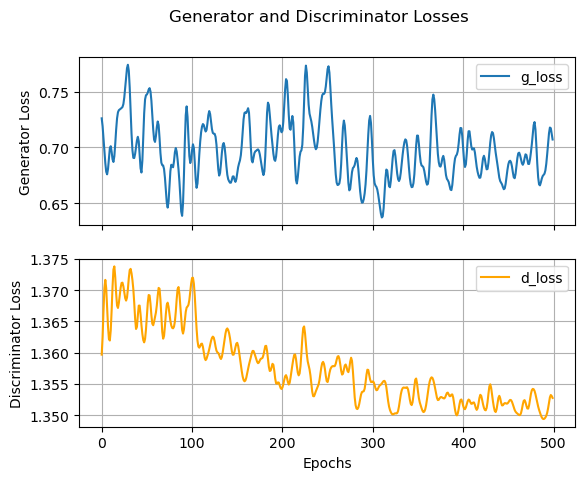

In [13]:
%%time

plot_losses(history=hist, sigma=SIGMA, save=True, savepath=WRITEPATH)

### Generate Molecules Using Trained GAN Generator 

In [14]:
%%time

gen_smiles = generate_smiles(n_gen, vocab, num_samples=N_SAMPLES, max_length=MAX_LENGTH, device=DEVICE)

print('\n')



CPU times: user 18 s, sys: 367 ms, total: 18.4 s
Wall time: 17.6 s


### Check Validity

In [15]:
%%capture

valid_smiles, invalid_smiles = check_smiles_validity(gen_smiles)

### Check Novelty

In [16]:
%%time

known_can_smiles = process_smiles_in_parallel(smiles_list=smilesList, function_object=canonicalize_smiles, n_processors=N_PROCESSORS)
print('\nLen known canonical smiles: ', len(known_can_smiles))

##iterate over unique valid smiles generations, then compare with known smiles
print('\nChecking Novelty of Unique GAN Generated Samples')
novel_smiles = [] 
for smiles in list(set(valid_smiles)):
    can_smiles = canonicalize_smiles(smiles)
    if is_novel(can_smiles, known_can_smiles):
        novel_smiles.append(smiles)

print('\nNovel Cnt: ', len(novel_smiles))
print('\n----------------------Novel Smiles----------------------')
for i, smiles in enumerate(novel_smiles):
    print(f'\n{i}. {smiles}')
print('\n')


Len known canonical smiles:  249456

Checking Novelty of Unique GAN Generated Samples

Novel Cnt:  14

----------------------Novel Smiles----------------------

0. CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1

1. CN(C)C(=O)CN1CCCN(C)C(=O)CN1CCCN(C)C(=O)CN1CCCN(C)C(=O)CN1CCCN(C)C(=O)CN1CCCN(C)C(=O)CN1CCCN(C)C(=O)CN1CCCN(C)C(=O)CN1CCCN(C)C(=O)CN1CCCN(C)C(=O)CN1CC

2. Cc1nn(C)c(C)c1CC(=O)NCC1(CC(C)C)CCCC1Cc1nn(C)c(C)c1CC(=O)NCC1(CC(C)C)CCCC1Cc1nn(C)c(C)c1CC(=O)NCC1(CC(C)C)CCCC1Cc1nn(C)c(C)c1CC(=O)NCC1(CC(C)C)CCCC1Cc1nn(C

### Check Solubility

In [17]:
%%time

aq_scores_smilesList = process_smiles_in_parallel(smiles_list=smilesList, function_object=estimate_solubility, n_processors=N_PROCESSORS)
aq_scores_smilesList = MinMaxScaler().fit_transform(np.array(aq_scores_smilesList).reshape(-1, 1))
print('\nKnown Smiles Solubility Score (logS) Stats')
print('Min: ', np.round(np.min(aq_scores_smilesList), 3))
print('Max: ', np.round(np.max(aq_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(aq_scores_smilesList), 3))

GAN_aq_scores_smilesList = process_smiles_in_parallel(smiles_list=list(set(valid_smiles)), function_object=estimate_solubility, n_processors=N_PROCESSORS)
scaler = MinMaxScaler()
GAN_aq_scores_smilesList = scaler.fit_transform(np.array(GAN_aq_scores_smilesList).reshape(-1, 1))
print('\nGAN Generated Smiles Solubility Score (logS) Stats')
print('Min: ', np.round(np.min(GAN_aq_scores_smilesList), 3))
print('Max: ', np.round(np.max(GAN_aq_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(GAN_aq_scores_smilesList), 3))

##iterate over unique valid smiles generations, then compare with known smiles
print('\nGAN Generated Smiles Solubility Score (logS)')
logS_list = [estimate_solubility(i) for i in list(set(valid_smiles))]
logS = scaler.transform(np.array(logS_list).reshape(-1, 1))

for sol_score in logS:
    print('Solubility Score: ', np.round(sol_score.item(), 3))
print('\n')


Known Smiles Solubility Score (logS) Stats
Min:  0.0
Max:  1.0
Mean:  0.441

GAN Generated Smiles Solubility Score (logS) Stats
Min:  0.0
Max:  1.0
Mean:  0.551

GAN Generated Smiles Solubility Score (logS)
Solubility Score:  0.382
Solubility Score:  0.885
Solubility Score:  0.438
Solubility Score:  0.593
Solubility Score:  0.765
Solubility Score:  0.429
Solubility Score:  0.793
Solubility Score:  0.546
Solubility Score:  0.341
Solubility Score:  0.479
Solubility Score:  0.556
Solubility Score:  1.0
Solubility Score:  0.504
Solubility Score:  0.0


CPU times: user 318 ms, sys: 1.82 s, total: 2.14 s
Wall time: 10.8 s


In [18]:
logS[0].item()

0.3816692870635343

### Calculate Druglikeliness

In [19]:
%%time

qed_scores_smilesList = process_smiles_in_parallel(smiles_list=smilesList, function_object=calculate_qed, n_processors=N_PROCESSORS)
print('\nKnown Smiles Druglikeliness Score (QED) Stats')
print('Min: ', np.round(np.min(qed_scores_smilesList), 3))
print('Max: ', np.round(np.max(qed_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(qed_scores_smilesList), 3))
print('Std: ', np.round(np.std(qed_scores_smilesList), 3))

GAN_qed_scores_smilesList = process_smiles_in_parallel(smiles_list=list(set(valid_smiles)), function_object=calculate_qed, n_processors=N_PROCESSORS)
print('\nGAN Generated Smiles Druglikeliness Score (QED) Stats')
print('Min: ', np.round(np.min(GAN_qed_scores_smilesList), 3))
print('Max: ', np.round(np.max(GAN_qed_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(GAN_qed_scores_smilesList), 3))
print('Std: ', np.round(np.std(GAN_qed_scores_smilesList), 3))

print('\nGAN Generated Smiles Druglikeliness Score (QED)')
for i, smiles in enumerate(list(set(valid_smiles))):
    qed_score = calculate_qed(smiles)
    print(f"{i}. QED score: {qed_score}")
print('\n')


Known Smiles Druglikeliness Score (QED) Stats
Min:  0.117
Max:  0.948
Mean:  0.732
Std:  0.139

GAN Generated Smiles Druglikeliness Score (QED) Stats
Min:  0.007
Max:  0.077
Mean:  0.022
Std:  0.017

GAN Generated Smiles Druglikeliness Score (QED)
0. QED score: 0.032
1. QED score: 0.077
2. QED score: 0.017
3. QED score: 0.017
4. QED score: 0.019
5. QED score: 0.017
6. QED score: 0.016
7. QED score: 0.007
8. QED score: 0.034
9. QED score: 0.011
10. QED score: 0.013
11. QED score: 0.013
12. QED score: 0.016
13. QED score: 0.017


CPU times: user 362 ms, sys: 1.82 s, total: 2.19 s
Wall time: 24.1 s


### Calculate Synthesizeability

In [21]:
%%capture

##gen scores for all smiles
sa_scores_smilesList = process_smiles_in_parallel(smiles_list=smilesList, 
                                                 function_object=calculate_sa_score, 
                                                 n_processors=N_PROCESSORS)

##gen scores for GAN generated samples
GAN_sa_scores_smilesList = process_smiles_in_parallel(smiles_list=list(set(valid_smiles)), 
                                                      function_object=calculate_sa_score, 
                                                      n_processors=N_PROCESSORS)

In [22]:
print('\nKnown Smiles Synthesizeability Score (SA) Stats')
print('Min: ', np.round(np.min(sa_scores_smilesList), 3))
print('Max: ', np.round(np.max(sa_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(sa_scores_smilesList), 3))
print('Std: ', np.round(np.std(sa_scores_smilesList), 3))

print('\nGAN Generated Smiles Synthesizeability Score (SA) Stats')
print('Min: ', np.round(np.min(GAN_sa_scores_smilesList), 3))
print('Max: ', np.round(np.max(GAN_sa_scores_smilesList), 3))
print('Mean: ', np.round(np.mean(GAN_sa_scores_smilesList), 3))
print('Std: ', np.round(np.std(GAN_sa_scores_smilesList), 3))

print('\nUnique Valid GAN Generated Sample SA Scores')
for i, sa_score in enumerate(GAN_sa_scores_smilesList):
    print(f"{i}. SA score: {sa_score}")
print('\n')


Known Smiles Synthesizeability Score (SA) Stats
Min:  0.261
Max:  6.566
Mean:  0.888
Std:  0.427

GAN Generated Smiles Synthesizeability Score (SA) Stats
Min:  0.244
Max:  0.839
Mean:  0.453
Std:  0.163

Unique Valid GAN Generated Sample SA Scores
0. SA score: 0.244
1. SA score: 0.839
2. SA score: 0.446
3. SA score: 0.298
4. SA score: 0.497
5. SA score: 0.287
6. SA score: 0.444
7. SA score: 0.441
8. SA score: 0.378
9. SA score: 0.646
10. SA score: 0.307
11. SA score: 0.558
12. SA score: 0.633
13. SA score: 0.317




### Get Summary Stats

In [25]:
%%time

print("\n\n==================================================Stats==================================================")
basic_stats = summary_stats(valid_smiles, invalid_smiles)

print("\n\n===============================================Valid SMILES===============================================")
for i, smiles in enumerate(list(set(valid_smiles))[: 10]):
    print(f'\n{i}.  {smiles}')

print("\n\n===============================================Inalid SMILES===============================================")
for i, smiles in enumerate(list(set(invalid_smiles))[: 10]):
    print(f'\n{i}.  {smiles}')

print('\n')



==================================================Stats==================================================
total generated cnt:  1000
valid cnt:  271
invalid Count:  729
unique valid cnt:  14
unique invalid cnt:  56
percent unique valid:  1.4
percent unique invalid:  5.6
ratio unique_valid/unique_invalid:  0.25


===============================================Valid SMILES===============================================

0.  CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1CCn1c(CN2CCCCCC2=O)nnc1SCC(=O)N1CCN(c2cccc(C)c2C)CC1

1.  CN(C)C(=O)CN1CCCN(C)C(=O)CN1CCCN(C)C(=O)CN1CCC

### Visualize GAN Generated Molecules

CPU times: user 24.7 ms, sys: 1.16 ms, total: 25.9 ms
Wall time: 25.7 ms


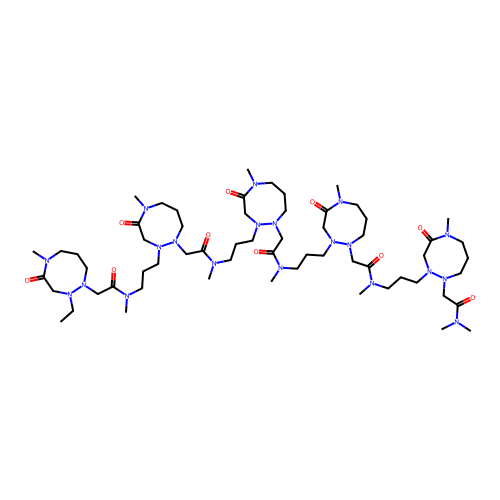

In [26]:
%%time

##plot a single example
img = plot_single_mol(list(set(valid_smiles))[1])
img.save(WRITEPATH + '/GAN_generated_img.png')
img

CPU times: user 2.17 s, sys: 5.58 ms, total: 2.17 s
Wall time: 2.16 s


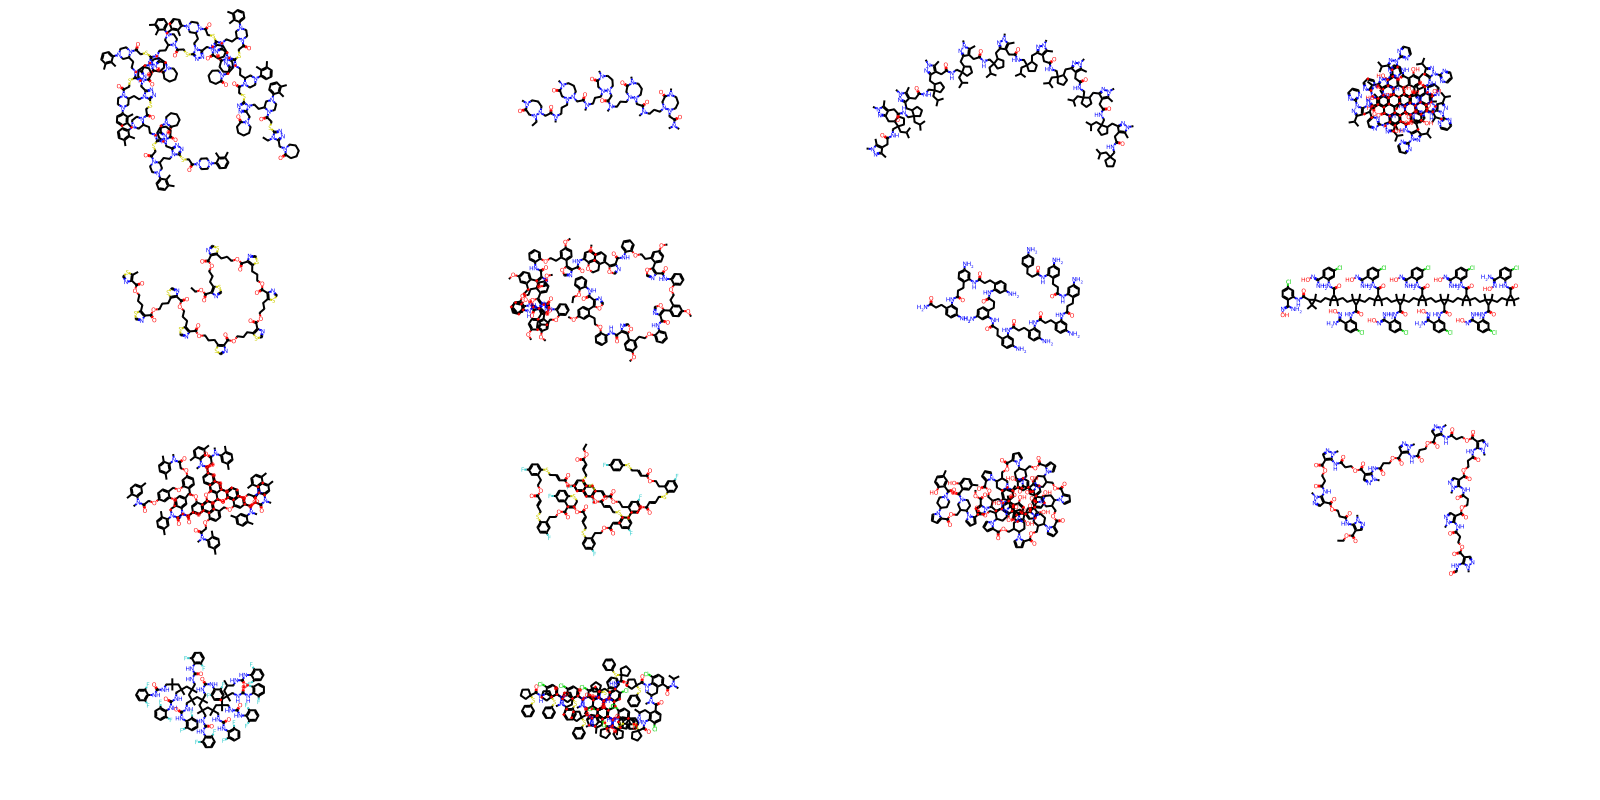

In [27]:
%%time

grid_img = plot_smiles_grid(smiles_list=list(set(valid_smiles)))
with open(WRITEPATH + "/grid_gan_generated.png", "wb") as f:
    f.write(grid_img.data)

grid_img

In [28]:
##clean and time
gc.collect()
torch.cuda.empty_cache()
tf = time.time()
print('Total Runtime: ', np.round(tf - t0, 3))

Total Runtime:  34416.891


### REFERENCES

Alqahtani, H. E. (2019, Dec 19). Applications of Generative Adversarial Networks (GANS): An Updated Review.

Arjovsky, M. E. (2017, Jan 26). Wasserstein GAN.

Bidisha, S. (2019). NeVAE: A Deep Generative Model for Molecular Graphs.

Goodfellow, E. A. (2014, June 10). Generative Adversarial Networks.

Jaun-Ni Wu, E. A. (2024). t-SMILES: A Fragment-based Molecular Representation Framework for De Novo Ligand Design. Hunan, China.

National Library of Medicine. (2024, July 22). National Center for Biotechnology Information. Retrieved from PubChem: https://pubchem.ncbi.nlm.nih.gov/

Nicola De Cao, T. K. (2018). MolGAN: An Implicit Generative Model for Small Molecular Graphs. Stochholm, Sweden.